# 0. Basic Setup and Exploration

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

# import sklearn packages
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot as plt
#from sklearn.neural_network import MLPRegressor
from math import sqrt

# import visualization libraries
from IPython.display import Image  
import pydotplus
from sklearn.externals.six import StringIO

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# make the output stable across runs
np.random.seed(42)

In [2]:
# read the data
wine_raw = pd.read_csv('wine.csv')

In [3]:
# glimpse the data
print("Shape of Wine data:\nrows:", wine_raw.shape[0], '\ncolumns:', wine_raw.shape[1])

Shape of Wine data:
rows: 1599 
columns: 12


In [4]:
wine_raw.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
wine_raw.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
# check missing data (There is no missing data in the entire dataset.)
total = wine_raw.isnull().sum().sort_values(ascending = False)
percent = (wine_raw.isnull().sum()/wine_raw.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,quality,alcohol,sulphates,ph,density,total_sulfur_dioxide,free_sulfur_dioxide,chlorides,residual_sugar,citric_acid,volatile_acidity,fixed_acidity
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# check data unbalance (The data has not a large unbalance with respect of the target value.)
# explore the target variable: quality
qualitydata = wine_raw.quality.value_counts().sort_index()
qualitydata_df = pd.DataFrame({'Quality': qualitydata.index,'Count': qualitydata.values})
qualitydata_df

,Quality,Count
0,3,10
1,4,53
2,5,681
3,6,638
4,7,199
5,8,18


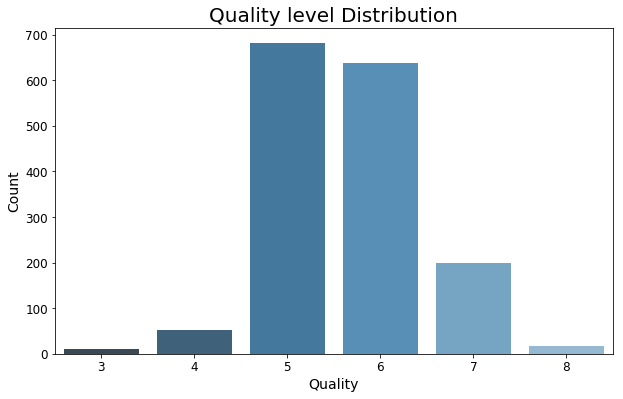

In [8]:
# visualize target variable
plt.figure(figsize=(10,6))
sns.barplot(x = 'Quality', y ="Count", data = qualitydata_df,palette="Blues_d")
plt.title('Quality level Distribution',fontsize=20)
plt.show()

# 1. Decision Tree Classification

## 1.1 Multi-class Classification

In [9]:
# Selecting the input and output features for tasks
features = ['fixed_acidity',
            'volatile_acidity',
            'citric_acid',
                'residual_sugar',
            'chlorides',
                'free_sulfur_dioxide',
            'total_sulfur_dioxide',
            'density',
                'ph',
            'sulphates',
            'alcohol']
target = ['quality']

X = wine_raw[features]
y = wine_raw[target]

# Visualize the combined table (which should looks the same as the original dataset)
# pd.concat([X, y], axis=1, sort=False).head()

In [10]:
# Split dataset into training set & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Fit on train set
# clf = DecisionTreeClassifier(max_features=5, max_depth=9, random_state=42) # Grid Search accuracy: 0.625
clf = DecisionTreeClassifier(max_features = 5, random_state = 42, max_depth = 5) # accuracy

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [12]:
# Test the accuracy
prediction = clf.predict(X_test)
print("Decision Tree Accuracy:",accuracy_score(y_test, prediction))

Decision Tree Accuracy: 0.615625


In [13]:
# cross validation Score
cv_clf = clf
cv_X_test = X_test
cv_y_test = y_test
cv_folds = 5
cv_scoring = None # default accuracy
cv_result = cross_val_score(cv_clf,cv_X_test,cv_y_test,cv=cv_folds,scoring=cv_scoring)
print(cv_result)
print('Mean: %.5f, Std: %.5f' % (np.mean(cv_result),np.std(cv_result)))

[0.44776119 0.640625   0.53125    0.50793651 0.5483871 ]
Mean: 0.53519, Std: 0.06276


/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


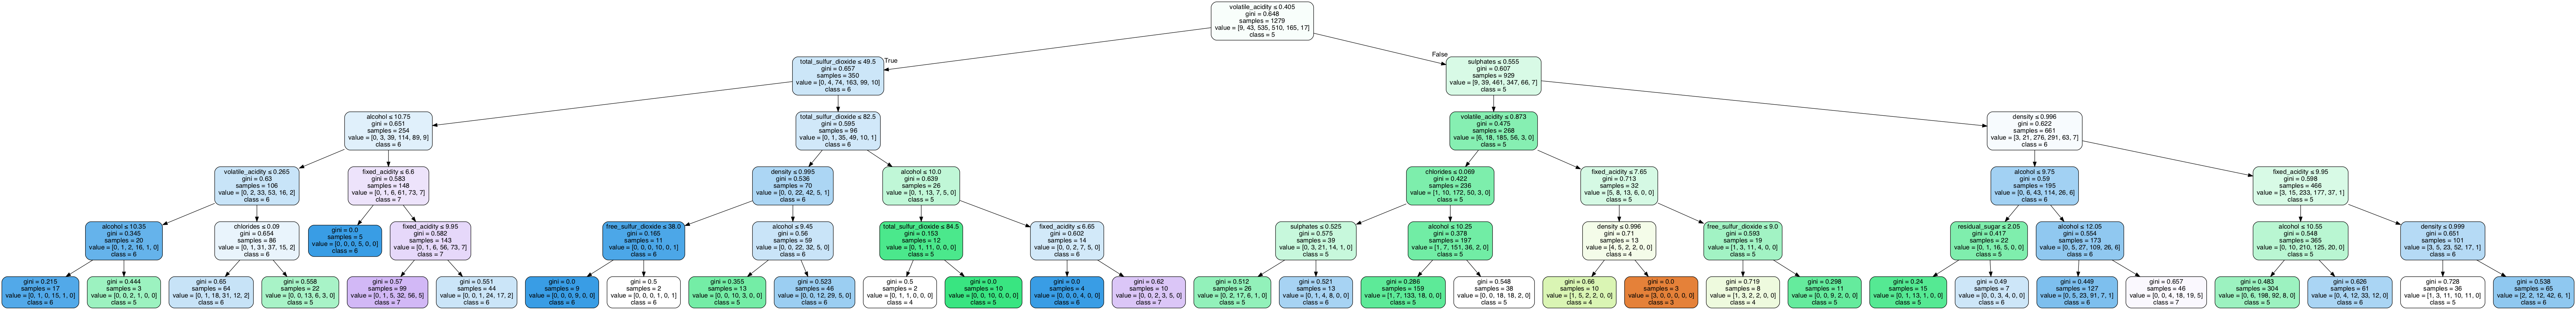

In [14]:
# Decision Tree Visualization - Multi-class
feature_names = np.array(features)
target_names = ['3','4','5','6','7','8']

dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=feature_names,
                         class_names=target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png("wine_dt_1.png")
Image(graph.create_png()) 

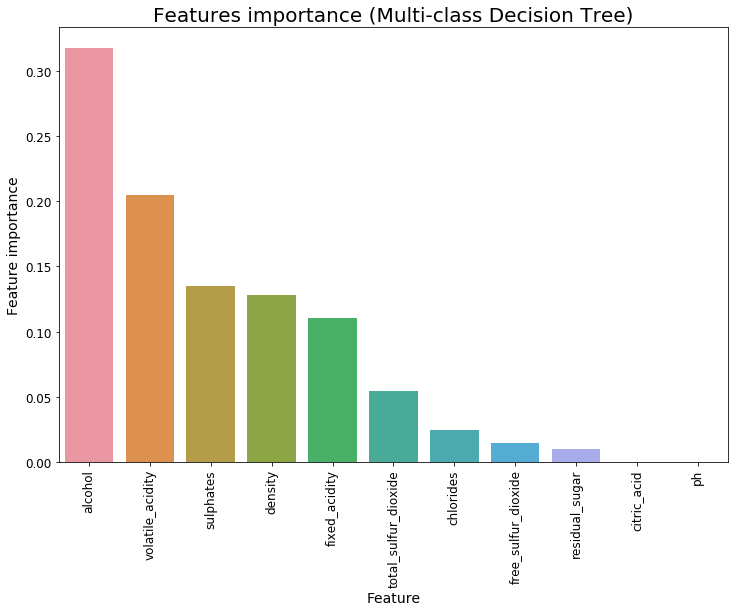

In [15]:
# Feature Importance Evaluation
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.
tmp = pd.DataFrame({'Feature': features, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (12,8))
plt.title('Features importance (Multi-class Decision Tree)',fontsize=20)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

Confusion matrix:
 [[  0   0   0   1   0   0]
 [  0   0   6   2   2   0]
 [  0   5 108  31   2   0]
 [  0   0  44  73  11   0]
 [  0   0   3  15  16   0]
 [  0   0   0   1   0   0]]


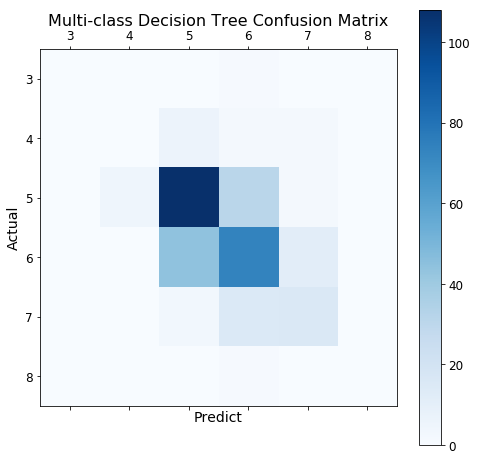

In [16]:
# print("Decision Tree Accuracy:",accuracy_score(y_test, clf.predict(X_test)))

conf_mat = confusion_matrix(y_test, clf.predict(X_test))
# plot_confusion_matrix(conf_mat, classes=class_names, title='Confusion matrix')
print('Confusion matrix:\n', conf_mat)

labels = [3,4,5,6,7,8]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predict')
plt.title('Multi-class Decision Tree Confusion Matrix',fontsize=16)
plt.ylabel('Actual')
plt.show()

In [17]:
# Grid Search for Decision Tree Multi-classification
classifier = DecisionTreeClassifier(random_state = 42)
parameters = {
              'max_depth': range(3,10),
              'max_features': range(3,10),
              'max_leaf_nodes':[5,10,20,100,200],
             }
scoring_fnc = make_scorer(accuracy_score)
kfold = KFold(n_splits=10)

grid = GridSearchCV(classifier, parameters, scoring_fnc, cv=kfold)
grid = grid.fit(X_train, y_train)

clf = grid.best_estimator_

print('best score: %f'%grid.best_score_)
print('best parameters:')
for key in parameters.keys():
    print('%s: %d'%(key, clf.get_params()[key]))

print('test score: %f'%clf.score(X_test, y_test))

pd.DataFrame(grid.cv_results_).T

best score: 0.592651
best parameters:
max_depth: 9
max_features: 5
max_leaf_nodes: 200
test score: 0.628125


/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/simon/anaconda3/lib/pyth

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
mean_fit_time,0.00230563,0.00423377,0.00319793,0.00255241,0.00229814,0.00238497,0.00307837,0.00324624,0.00294266,0.00373678,...,0.00296073,0.00351338,0.00405126,0.00542438,0.00588076,0.00344021,0.0037631,0.00397325,0.0053175,0.00589011
std_fit_time,0.000330307,0.000950391,0.000659012,0.000406617,0.000151454,0.0002802,0.000551825,0.000619958,0.000440698,0.00119936,...,0.000208036,0.00044955,0.000361934,0.000361328,0.000161658,0.000351101,0.000259111,0.000119942,0.000103183,0.000228728
mean_score_time,0.000610113,0.00111871,0.000970912,0.000660515,0.000658107,0.000657701,0.000809073,0.000932217,0.000679255,0.00101619,...,0.000612617,0.000632453,0.000606418,0.000604367,0.000789118,0.00075469,0.000690126,0.000579715,0.000540113,0.000576019
std_score_time,0.000121961,0.000285113,0.000391036,0.00011969,0.00023717,0.000131601,0.000205555,0.000315822,0.000155321,0.000551782,...,0.000103682,0.000103418,9.37402e-05,7.33235e-05,0.000123975,0.000151111,0.000177508,5.53621e-05,3.46576e-05,5.65759e-05
param_max_depth,3,3,3,3,3,3,3,3,3,3,...,9,9,9,9,9,9,9,9,9,9
param_max_features,3,3,3,3,3,4,4,4,4,4,...,8,8,8,8,8,9,9,9,9,9
param_max_leaf_nodes,5,10,20,100,200,5,10,20,100,200,...,5,10,20,100,200,5,10,20,100,200
params,"{'max_depth': 3, 'max_features': 3, 'max_leaf_...","{'max_depth': 3, 'max_features': 3, 'max_leaf_...","{'max_depth': 3, 'max_features': 3, 'max_leaf_...","{'max_depth': 3, 'max_features': 3, 'max_leaf_...","{'max_depth': 3, 'max_features': 3, 'max_leaf_...","{'max_depth': 3, 'max_features': 4, 'max_leaf_...","{'max_depth': 3, 'max_features': 4, 'max_leaf_...","{'max_depth': 3, 'max_features': 4, 'max_leaf_...","{'max_depth': 3, 'max_features': 4, 'max_leaf_...","{'max_depth': 3, 'max_features': 4, 'max_leaf_...",...,"{'max_depth': 9, 'max_features': 8, 'max_leaf_...","{'max_depth': 9, 'max_features': 8, 'max_leaf_...","{'max_depth': 9, 'max_features': 8, 'max_leaf_...","{'max_depth': 9, 'max_features': 8, 'max_leaf_...","{'max_depth': 9, 'max_features': 8, 'max_leaf_...","{'max_depth': 9, 'max_features': 9, 'max_leaf_...","{'max_depth': 9, 'max_features': 9, 'max_leaf_...","{'max_depth': 9, 'max_features': 9, 'max_leaf_...","{'max_depth': 9, 'max_features': 9, 'max_leaf_...","{'max_depth': 9, 'max_features': 9, 'max_leaf_..."
split0_test_score,0.601562,0.546875,0.546875,0.546875,0.546875,0.554688,0.601562,0.585938,0.585938,0.585938,...,0.585938,0.5625,0.585938,0.609375,0.609375,0.585938,0.585938,0.617188,0.664062,0.632812
split1_test_score,0.515625,0.515625,0.523438,0.523438,0.523438,0.5,0.484375,0.507812,0.507812,0.507812,...,0.476562,0.585938,0.601562,0.632812,0.664062,0.492188,0.507812,0.59375,0.617188,0.59375


## 1.2 Binary Classification

In [24]:
# Convert to a Binary Classification Task
# From the confusion matrix above, we can see a clear boundary between level 5 & 6
# Create a new column called Quality Label. This column will contain the values of 0 & 1
# where 1 = good, 0 = bad
wine2 = wine_raw
wine2['quality_label'] = (wine2['quality'] > 5.5)*1
wine2.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


0    744
1    855
Name: quality_label, dtype: int64


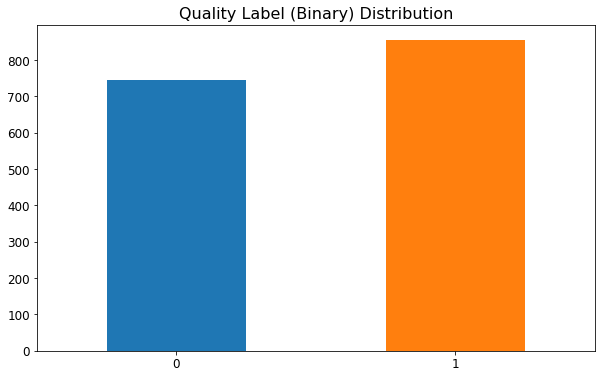

In [25]:
# explore the binary target variable: quality_label
ql_count = wine2.quality_label.value_counts().sort_index()
print(ql_count)
plt.figure(figsize=(10,6))
plt.title('Quality Label (Binary) Distribution',fontsize=16)
ql_hist = ql_count.plot(kind='bar');
ql_hist.set_xticklabels(ql_hist.get_xticklabels(),rotation=0)
plt.show() 

In [26]:
# Selecting the input and output features for classification tasks
features2 = ['fixed_acidity',
             'volatile_acidity',
             'citric_acid',
             'residual_sugar',
             'chlorides',
            'free_sulfur_dioxide',
             'total_sulfur_dioxide',
             'density',
             'ph',
             'sulphates',
             'alcohol']
target2 = ['quality_label']

In [27]:
X2 = wine2[features2]
y2 = wine2[target2]

In [28]:
# Split dataset
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=200)

In [29]:
# Fit on train set
# wine_clf = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=200)
clf2 = DecisionTreeClassifier(max_depth = 6, max_features = 6, random_state = 42)
clf2.fit(X2_train, y2_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [30]:
# Measure plain accuracy of the classifier
prediction2 = clf2.predict(X2_test)
accuracy_score(y_true=y2_test, y_pred=prediction2)

0.740625

In [31]:
# Cross Validation - Decision Tree Binary
cv_clf = clf2
cv_X_test = X2_test
cv_y_test = y2_test
cv_folds = 5
cv_scoring = None 
cv_scoring1 = 'roc_auc'
cv_result = cross_val_score(cv_clf,cv_X_test,cv_y_test,cv=cv_folds,scoring=cv_scoring)
cv_result1 = cross_val_score(cv_clf,cv_X_test,cv_y_test,cv=cv_folds,scoring=cv_scoring1)
print(cv_result)
print(cv_result1)
print('Plain: Mean %.5f, Std %.5f' % (np.mean(cv_result),np.std(cv_result)))
print('  AUC: Mean %.5f, Std %.5f' % (np.mean(cv_result1),np.std(cv_result1)))

[0.61538462 0.76923077 0.734375   0.73015873 0.65079365]
[0.68702652 0.78219697 0.72091887 0.75453629 0.72580645]
Plain: Mean 0.69999, Std 0.05738
  AUC: Mean 0.73410, Std 0.03222


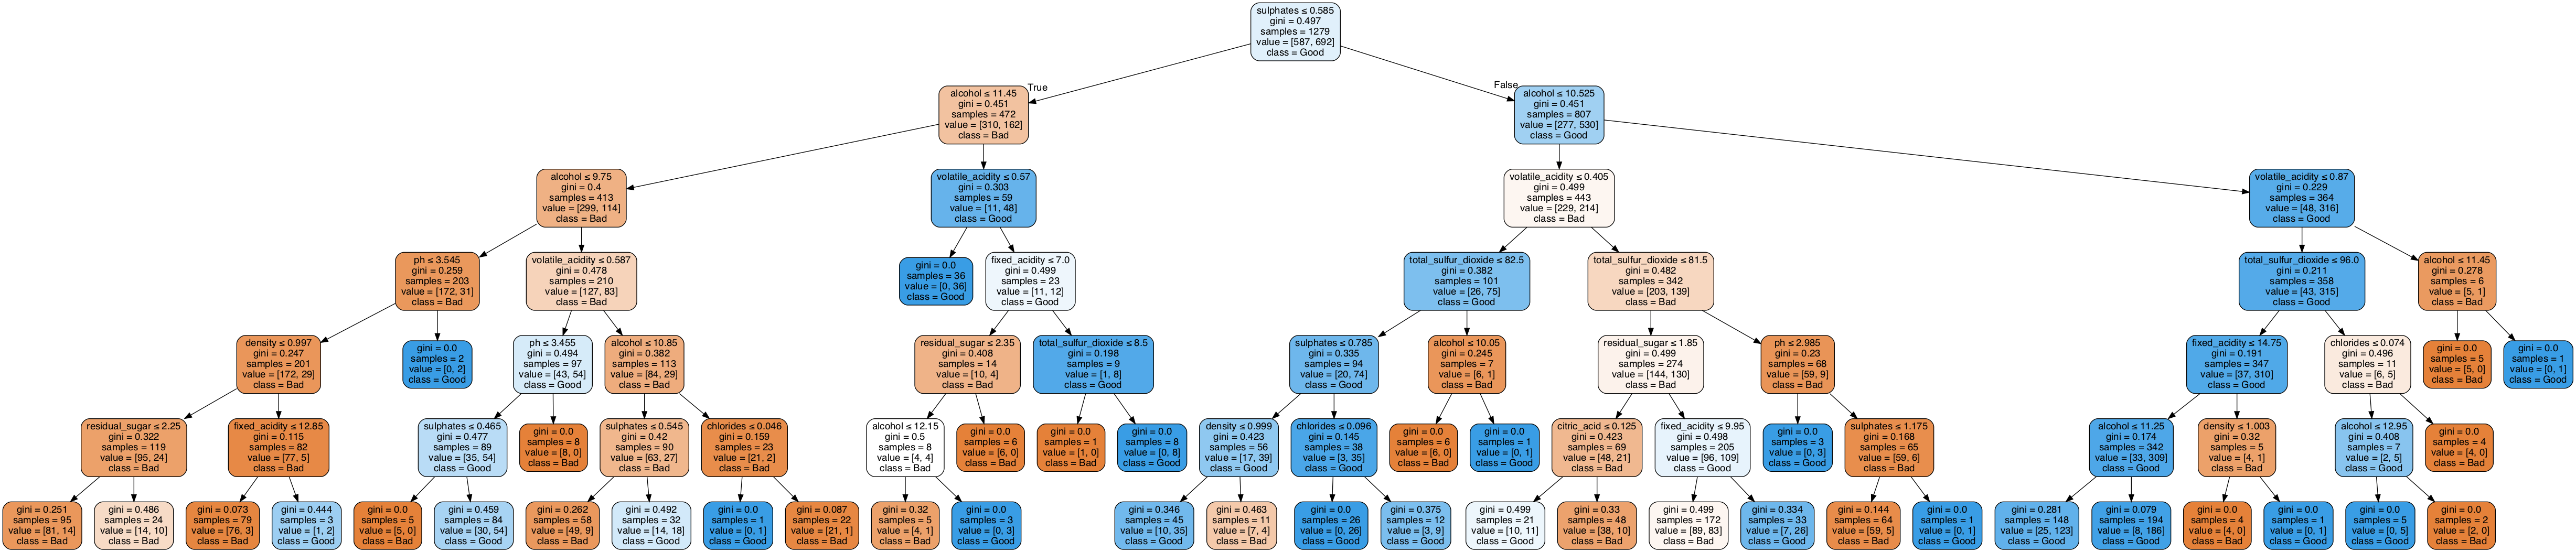

In [32]:
# Decision Tree Visualisation - Binary
feature_names2 = np.array(features)
target_names2 = ['Bad','Good']

dot_data = tree.export_graphviz(clf2, out_file=None,
                         feature_names=feature_names2,
                         class_names=target_names2,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png("wine_dt_2.png")
Image(graph.create_png()) 

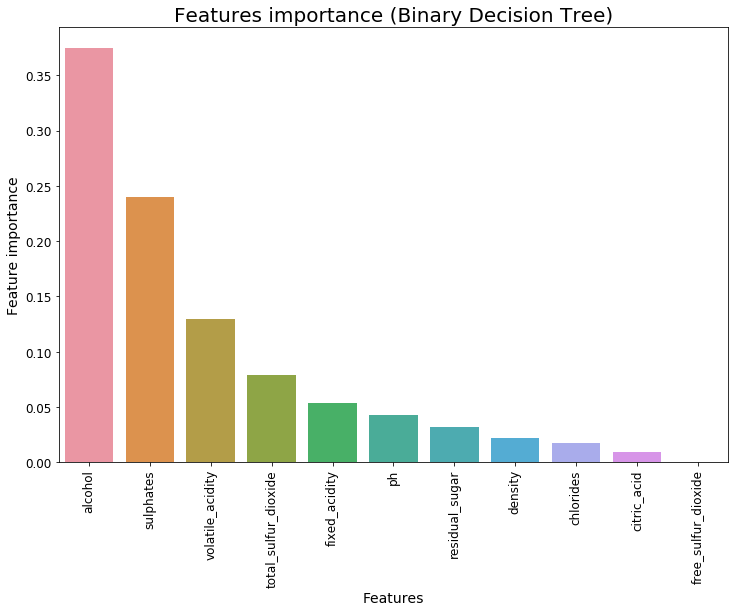

In [28]:
tmp = pd.DataFrame({'Features': features2, 'Feature importance': clf2.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (12,8))
plt.title('Features importance (Binary Decision Tree)',fontsize=20)
s = sns.barplot(x='Features',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

Confusion matrix:
 [[114  43]
 [ 40 123]]


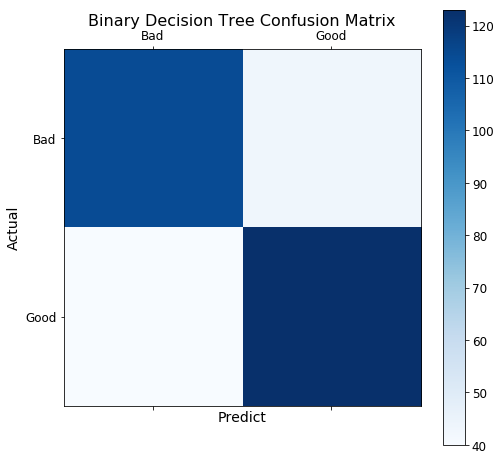

In [132]:
# Confusion Matrix - Binary Decision Tree
conf_mat = confusion_matrix(y2_test, clf2.predict(X_test))
print('Confusion matrix:\n', conf_mat)

labels = ['Bad', 'Good']
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Binary Decision Tree Confusion Matrix',fontsize=16)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

0.8115743816185379


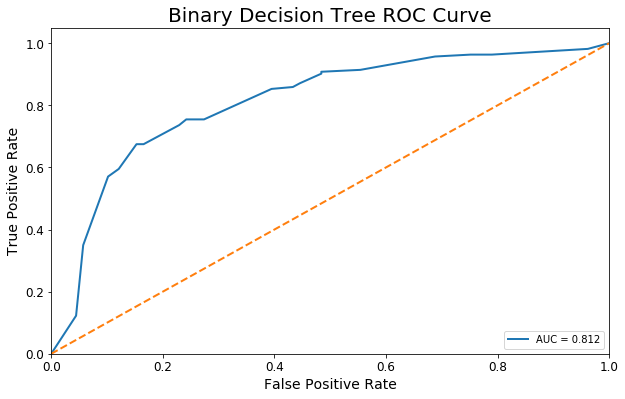

In [133]:
# Plot the ROC Curve
probs = clf2.predict_proba(X2_test) # Predict class probabilities of the input samples 
preds = probs[:,1]
y2_score = clf2.fit(X2_train, y2_train).predict_proba(X2_test)
 
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y2_test, preds) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

print(roc_auc)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, lw=2, label='AUC = %0.3f' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Decision Tree ROC Curve',fontsize=20)
plt.legend(loc="lower right")
plt.show()

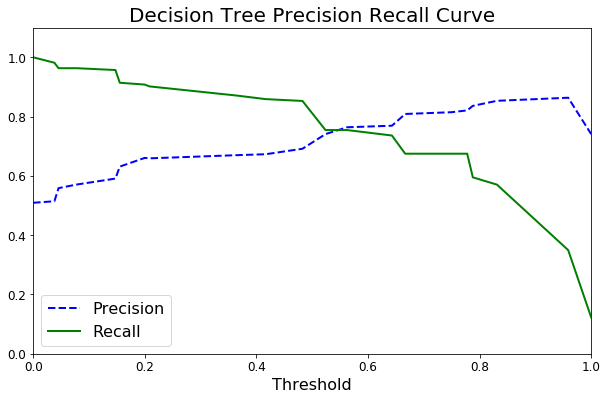

In [33]:
# Plot the precision recall curve
precisions, recalls, thresholds = precision_recall_curve(y2_test, preds)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower left", fontsize=16)
    plt.ylim([0, 1.1])
    
plt.figure(figsize=(10,6))
plt.title('Decision Tree Precision Recall Curve',fontsize=20)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])
plt.show()

In [21]:
# Grid Search for Decision Tree Binary
classifier = DecisionTreeClassifier(random_state = 42)
parameters = {
              'max_depth': range(3,10),
              'max_features': range(3,10),
              'max_leaf_nodes':[5,10,20,100,200],
             }
scoring_fnc = make_scorer(accuracy_score)
kfold = KFold(n_splits=10)

grid = GridSearchCV(classifier, parameters, scoring_fnc, cv=kfold)
grid = grid.fit(X2_train, y2_train)

clf = grid.best_estimator_

print('best score: %f'%grid.best_score_)
print('best parameters:')
for key in parameters.keys():
    print('%s: %d'%(key, clf.get_params()[key]))

print('test score: %f'%clf.score(X2_test, y2_test))

pd.DataFrame(grid.cv_results_).T

NameError: name 'X2_train' is not defined

# 2. Random Forest

## 2.1 Multi-class

In [139]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/simon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [140]:
print("Multi-class Random Forest Accuracy:", accuracy_score(y_test, rf_clf.predict(X_test)))

Multi-class Random Forest Accuracy: 0.659375


In [18]:
# cross validation Score - Multi-class Random Forest
cv_clf = rf_clf
cv_X_test = X_test
cv_y_test = y_test
cv_folds = 5
cv_scoring = None # default accuracy
cv_result = cross_val_score(cv_clf,cv_X_test,cv_y_test,cv=cv_folds,scoring=cv_scoring)
print('cross validation - Random Forest Multi-class')
print(cv_result)
print('Mean: %.5f, Std: %.5f' % (np.mean(cv_result),np.std(cv_result)))

NameError: name 'rf_clf' is not defined

In [19]:
tmp = pd.DataFrame({'Feature': features, 'Feature importance': rf_clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (12,8))
plt.title('Features importance (Multi-class Random Forest)',fontsize=20)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

NameError: name 'rf_clf' is not defined

In [20]:
# plot the confusion matrix
conf_mat = confusion_matrix(y_test, rf_clf.predict(X_test))
print('Confusion matrix:\n', conf_mat)

labels = [3,4,5,6,7,8]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Multi-class Random Forest Confusion Matrix',fontsize=16)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

NameError: name 'rf_clf' is not defined

## 2.2 Binary

In [38]:
rf_clf2 = RandomForestClassifier()
rf_clf2.fit(X2_train, y2_train)

/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/simon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
print("Binary Random Forest Accuracy:", accuracy_score(y2_test, rf_clf2.predict(X2_test)))

Binary Random Forest Accuracy: 0.7875


In [135]:
# Cross Validation - Random Forest Binary
cv_clf = rf_clf2
cv_X_test = X2_test
cv_y_test = y2_test
cv_folds = 5
cv_scoring = None 
cv_scoring1 = 'roc_auc'
cv_result = cross_val_score(cv_clf,cv_X_test,cv_y_test,cv=cv_folds,scoring=cv_scoring)
cv_result1 = cross_val_score(cv_clf,cv_X_test,cv_y_test,cv=cv_folds,scoring=cv_scoring1)
print(cv_result)
print(cv_result1)
print('Plain: Mean %.5f, Std %.5f' % (np.mean(cv_result),np.std(cv_result)))
print('  AUC: Mean %.5f, Std %.5f' % (np.mean(cv_result1),np.std(cv_result1)))

[0.76923077 0.8        0.734375   0.66666667 0.77777778]
[0.83285985 0.80018939 0.76637341 0.80090726 0.84425403]
Plain: Mean 0.74961, Std 0.04654
  AUC: Mean 0.80892, Std 0.02747


/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConvers

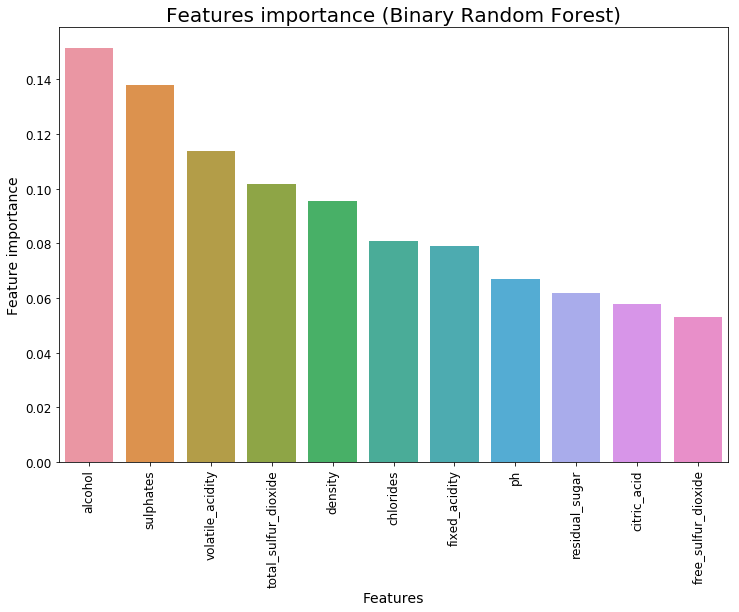

In [40]:
tmp = pd.DataFrame({'Features': features2, 'Feature importance': rf_clf2.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (12,8))
plt.title('Features importance (Binary Random Forest)',fontsize=20)
s = sns.barplot(x='Features',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Confusion matrix:
 [[130  27]
 [ 41 122]]


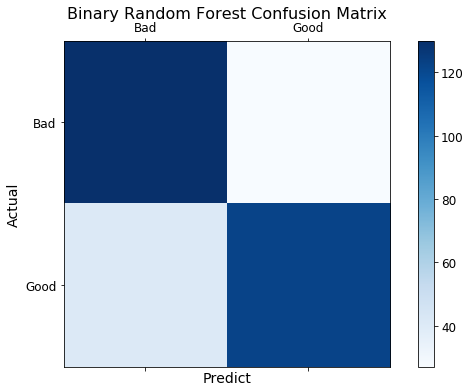

In [41]:
conf_mat = confusion_matrix(y2_test, rf_clf2.predict(X2_test))
print('Confusion matrix:\n', conf_mat)

labels = ['Bad', 'Good']
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Binary Random Forest Confusion Matrix',fontsize=16)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [42]:
from sklearn.model_selection import cross_val_predict, cross_val_score
cv = 5
print('Score(AUC): %.5f +/- %.4f' % (np.mean(cross_val_score(rf_clf2,X2_test,y2_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(rf_clf2,X2_test,y2_test,cv=cv,scoring='roc_auc'))))

Score(AUC): 0.80621 +/- 0.0493


/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConvers

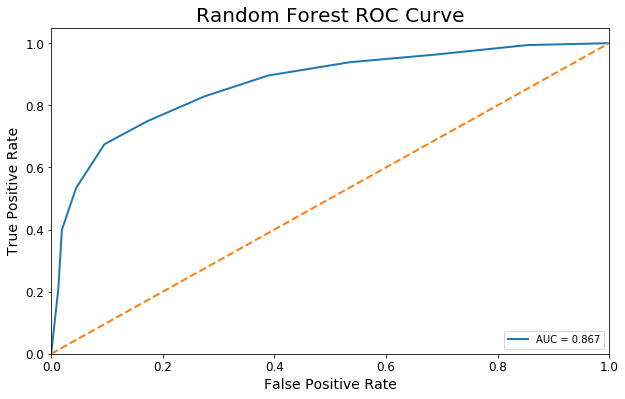

In [43]:
# Plot the ROC Curve
rf_probs = rf_clf2.predict_proba(X2_test) # Predict class probabilities of the input samples 
rf_preds = rf_probs[:,1]
 
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y2_test, rf_preds) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, lw=2, label='AUC = %0.3f' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=20)
plt.legend(loc="lower right")
plt.show()

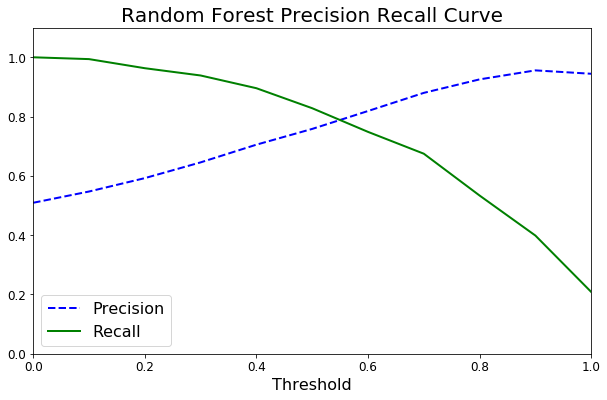

In [44]:
# Plot the precision recall curve
precisions, recalls, thresholds = precision_recall_curve(y2_test, rf_preds)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower left", fontsize=16)
    plt.ylim([0, 1.1])
    
plt.figure(figsize=(10,6))
plt.title('Random Forest Precision Recall Curve',fontsize=20)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])
plt.show()

# 3. Conclusion

- The dataset is relatively small, 1599 observations. (A larger dataset is found with 6497 observations, similar result);
- The dataset is special so the fields might not be widely available in industry wise;
- For the future use, we might have limited fields data available so the model could not work as this dataset, for example 3 most important variables: alcohol, sulphates, volatile acidity;
- Use grid search to optimise the hyper-parameters of Random Forest;